# Doc2vec for HP fanfics on Fanfiktion.de

In [6]:
import re
import os
from pathlib import Path
import pickle
import glob
import random
import ast

import spacy
import pandas as pd

import numpy as np
from numpy import dot
from numpy.linalg import norm

from itertools import chain

from scipy import sparse
from scipy.spatial import distance
from statistics import mean 
from scipy.spatial import distance_matrix

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import collections
import random
from heapq import nsmallest 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import string

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import multiprocessing
cores = multiprocessing.cpu_count()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx

C:\Users\LitLab\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Functions

In [7]:
# cleanup_quotationsMarks(text)
#
# Cleans up a text by replacing curly quotations marks by standard quotations marks.
# @param text string object
# return string

def cleanup_quotationsMarks(text):
    cleaned = re.sub(r'[”‟»«„“]', '"', text)
    return(cleaned)

In [8]:
# replaceNames(entity_dict, texts_str)
#
# Replaces occurring names by a common entity name
# @param entity dict dictionary containing the name variations with corresponding entity names
# @param texts_str string object
# return string

def replaceNames(entity_dict, text):
    for name, synonyms in entity_dict.items():
        for synonym in synonyms:
            if synonym in text:
                #print('found ', synonym, ', replaced by ', name)
                text = re.sub(r'\b'+synonym+r's*\b', name, text)
    return text

In [9]:
# preprocess(texts, nlp_model, chunk_size, sentence_punct)
#
# Preprocesses a list of texts by splitting them up in smaller chunks.
# @param texts list of string objects
# @param nlp_model pre-loaded spacy nlp model
# @param chunk_size int defining the approximate size of the chunks (the chunks end with the next sentence punctuation)
# @param sentence_punkt string of puncuations markers that define sentence breaks, default = "?.!"
# return tuple consisting of a list of preprocessed string objects and a list of chapter ids

def preprocess(texts, nlp_model, chunk_size, chap_ids, fullnames_dict, names_dict, sentence_punct="?.!"):
    index = 0
    texts_out = []
    chap_id = []
    too_long = []
    too_long_ids = []
    for text in texts:
        if text == 'geschichte ist nicht zugaenglich ':
            print('\n\nText not accessible!\n\n')
            continue
        #print('\n\n----------------', len(text), '----------------\n\n')
        if len(text) > 4000000:
            too_long.append(text)
            too_long_ids.append(ids_HPFF[index])
            continue
        print(chap_ids[index])
        text = replaceNames(fullnames_dict, text)
        text = replaceNames(names_dict, text)
        doc = nlp_model(text)
        new_text = [[tok.text for tok in sents 
             if tok.text != " " 
             and tok.text != "\n"] for sents in doc.sents]
        new_text = [item for sublist in new_text for item in sublist]
        if new_text:
            paragraphs = []
            start = 0
            end = chunk_size
            x = 0
            if len(new_text) <= chunk_size:
                paragraphs.append(new_text)
                chap_id.append(chap_ids[index])
            else: 
                while end + 100 <= len(new_text)-1:
                    while new_text[end] not in sentence_punct:
                        end += 1
                    paragraphs.append(new_text[start:end+1])
                    print("appended")
                    new_id = "_".join([chap_ids[index], str(x)])
                    #print(new_id)
                    chap_id.append(new_id)
                    start = end + 2
                    end += chunk_size
                    x += 1
            texts_out.append(paragraphs)
        print('\n\n----------------Text no. ', index, ' done!----------------\n\n')
        index += 1
    return(texts_out, chap_id, too_long, too_long_ids)

### Data import

In [10]:
path_data = r'C:\Users\Brottrager\Documents\TeamWeitin\Werkstatt\HP-fanfic\pamphlet_character_shifts\data'
path_corpora = r'C:\Users\Brottrager\Documents\TeamWeitin\Werkstatt\HP-fanfic\pamphlet_character_shifts\corpora'
path_pickled = r'D:\Dokumente\doc2vec'

In [ ]:
file = open(path_data + '\\entities\\full_names.csv')
contents = file. read()
full_names_dict = ast.literal_eval(contents)

sorted_names_full_names = {}
for name, synonyms in full_names_dict.items():
    sorted_synonyms = list(sorted(synonyms, key = len, reverse = True))
    sorted_synonyms = [each_string.lower() for each_string in sorted_synonyms]
    sorted_names_full_names[name]= sorted_synonyms

file = open(path_data + '\\entities\\entities.csv')
contents = file. read()
names_dict = ast.literal_eval(contents)

sorted_names = {}
for name, synonyms in names_dict.items():
    sorted_synonyms = list(sorted(synonyms, key = len, reverse = True))
    sorted_synonyms = [each_string.lower() for each_string in sorted_synonyms]
    sorted_names[name]= sorted_synonyms

In [ ]:
files_HP = glob.glob(os.path.join(os.getcwd(), path_corpora + '\\originals', '*.txt'))
files_HPFF = glob.glob(os.path.join(os.getcwd(), path_corpora + '\\fanfics', '*.txt'))

In [ ]:
ids_HP = [re.sub(r'C:\\.+originals\\(.+).txt', '\\1', str(file)) for file in files_HP]
ids_HPFF = [re.sub(r'C:\\.+fanfics\\(.+).txt', '\\1', str(file)) for file in files_HPFF]

In [ ]:
texts_HP = []
for file in files_HP:
    with open (file, encoding = "utf8") as f:
        texts_HP.append(f.read()) 

In [ ]:
texts_HPFF = []
for file in files_HPFF:
    with open (file, encoding = "utf8") as f:
        texts_HPFF.append(f.read()) 

### Preprocessing

In [ ]:
texts_quotationsMarks_cleanup_HP = []
for text in texts_HP:
    texts_quotationsMarks_cleanup_HP.append(cleanup_quotationsMarks(text))
    
texts_quotationsMarks_cleanup_HPFF = []
for text in texts_HPFF:
    texts_quotationsMarks_cleanup_HPFF.append(cleanup_quotationsMarks(text))

In [ ]:
texts_HP_clean = [word.replace('\n',' ') for word in texts_quotationsMarks_cleanup_HP]
texts_HPFF_clean = [word.replace('\n',' ') for word in texts_quotationsMarks_cleanup_HPFF]

texts_HP_clean = [word.lower() for word in texts_HP_clean]
texts_HPFF_clean = [word.lower() for word in texts_HPFF_clean]

In [11]:
nlp = spacy.load("de_core_news_sm")
nlp.max_length = 4500000

In [ ]:
preprocessed_texts_HP = preprocess(texts_HP_clean, nlp, 2500, ids_HP, sorted_names_full_names, sorted_names)

In [ ]:
all_chunks_HP = []
list_ids = preprocessed_texts_HP[1]

counter = 0
for sublist in preprocessed_texts_HP:
    subcounter = 0
    for l in sublist:
        if len(l) != 0:
            all_chunks_HP.append([l[0], list_ids[subcounter]])
            subcounter += 1
    counter += 1

In [12]:
#with open(path_pickled + '\\preprocessed_texts_HP.pkl', 'wb') as f:
#    pickle.dump(preprocessed_texts_HP, f)

with open(path_pickled + '\\preprocessed_texts_HP.pkl', 'rb') as f:
    preprocessed_texts_HP = pickle.load(f)

In [ ]:
stop = len(texts_HPFF_clean)
list_preprocessed_texts = []
while stop > 0:
    start = stop - 10
    if start < 0:
        start = 0
    print('\n\n----------------!!! New round !!!----------------\n\n')
    print('Start index: ', start)
    print('Stop index: ', stop, '\n\n')
    x = preprocess(texts_HPFF_clean[start:stop], nlp, 2500, ids_HPFF[start:stop], sorted_names_full_names, sorted_names)
    list_preprocessed_texts.append(x)
    stop = stop - 10

In [13]:
#with open(path_pickled + '\\list_preprocessed_texts.pkl', 'wb') as f:
#    pickle.dump(list_preprocessed_texts, f)
    
with open(path_pickled + '\\list_preprocessed_texts.pkl', 'rb') as f:
    list_preprocessed_texts = pickle.load(f)

In [14]:
list_chunks = []
list_ids = []
todo_chunks = []
todo_ids = []

for l in list_preprocessed_texts:
    list_chunks.append([item for item in l[0]])
    list_ids.append([item for item in l[1]])
    todo_chunks.append([item for item in l[2]])
    todo_ids.append([item for item in l[3]])

In [15]:
ids = list(chain(*list_ids))

In [17]:
all_chunks_HPFF = []

counter = 0
for text in list_chunks:
    for l in text:
        if len(l) != 0:
            for x in l:
                all_chunks_HPFF.append([x, ids[counter]])
                print(ids[counter])
                counter += 1

5fedc71c0002e78a17f6c8b0_Das-riddlesche-Kalkuel_0
5fedc71c0002e78a17f6c8b0_Das-riddlesche-Kalkuel_1
5fedc99200090f2e36757766_Sexualkunde-in-Hogwarts_0
5fedeb3b000c65cf26d03006_Von-Fussbal-spielenden-Kaninchen
5fedebe8000b47f41e21882f_31-Dezember-Zwischen-den-Dimensionen-by-Sirala_0
5feded04000cb2621f209731_Harry-und-Hermine-unzertrennliche-Geschwister
5fee0122000b7f151ae93795_Happy-new-year
5fee0a07000b5da21bebe631_Ein-Tag-am-Strand_0
5fee0e48000a5a18cbd40ce_Unsichtbar-Adoptiert_0
5fee0e48000a5a18cbd40ce_Unsichtbar-Adoptiert_1
5fee531c000a9dd86ce5cec_Wahre-Liebe-kann-auch-noch-spaet-erbluehen
5fee5701000c5ccc150a130d_Silvester-im-Krankenfluegel
5fed00490004b7352d0ef075_Ein-Geschenk-von-Herzen
5fed0824000475e719564ff4_Wie-Schmetterlinge-so-zart_0
5fed0824000475e719564ff4_Wie-Schmetterlinge-so-zart_1
5fed0824000475e719564ff4_Wie-Schmetterlinge-so-zart_2
5fed0824000475e719564ff4_Wie-Schmetterlinge-so-zart_3
5fed0824000475e719564ff4_Wie-Schmetterlinge-so-zart_4
5fed0824000475e719564ff4_Wie

5fc013b30009555d16338427_Jordan_2
5fc0199a000c3d0d3aaddc49_Love--Life
5fc1189c000ca24ebeea314_Wenn-Schlangen-aneinander-geraten-Draco-und-Everly_0
5fc147e7000c78bc23b56761_So-gleich-und-doch-so-unterschiedlich
5fc14f6e00040e3f13428bf1_What-about-us_0
5fc14f6e00040e3f13428bf1_What-about-us_1
5fc14f6e00040e3f13428bf1_What-about-us_2
5fc14f6e00040e3f13428bf1_What-about-us_3
5fc14f6e00040e3f13428bf1_What-about-us_4
5fc14f6e00040e3f13428bf1_What-about-us_5
5fc14f6e00040e3f13428bf1_What-about-us_6
5fc14f6e00040e3f13428bf1_What-about-us_7
5fc14f6e00040e3f13428bf1_What-about-us_8
5fc14f6e00040e3f13428bf1_What-about-us_9
5fc14f6e00040e3f13428bf1_What-about-us_10
5fc14f6e00040e3f13428bf1_What-about-us_11
5fc14f6e00040e3f13428bf1_What-about-us_12
5fc14f6e00040e3f13428bf1_What-about-us_13
5fc16044000b648919ac9582_Come-in
5fbd67bc000c17ab1cdea5c3_Das-Geheimnis-der-Olivanders
5fbd779300021bb611d786e0_Die-Verleihung-des-Goldenen-Besens_0
5fbd779300021bb611d786e0_Die-Verleihung-des-Goldenen-Besens_1
5

5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_3
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_4
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_5
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_6
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_7
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_8
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_9
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_10
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_11
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_12
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_13
5f9210d3000abdd01a12ff25_Elements-of-Perdition-A-riddles-solution_14
5f926f50000bef4b21d7537e_Wie-Sonne-und-Mond_0
5f8dce18000c816e269c88da_Halloween-Party_0
5f8de5640002e78a1127d2be_Schnuppertag-und-Geisterstunde_0
5f8e101a0006d7732298f140_You-hav

5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_11
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_12
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_13
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_14
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_15
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_16
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_17
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_18
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_19
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_20
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_21
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_22
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_23
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsprobleme_24
5f6d9e6100046fef27a8aa85_Liebe-Abenteuer-und-Beziehungsproblem

5f493fd7000092bd36c925cd_A-reckless-frame-of-mind_20
5f493fd7000092bd36c925cd_A-reckless-frame-of-mind_21
5f4950da000c5d268f3b38c_Ein-ziemlich-veraendertes-Leben-des-Harry-Potters_0
5f4950da000c5d268f3b38c_Ein-ziemlich-veraendertes-Leben-des-Harry-Potters_1
5f495b70000c21b333ef440c_Das-fuernehme-und-gar-alte-Haus-der
5f4966fc00079b942d85b48c_I-surrender_0
5f4751b5000baa81290ce5cf_Ein-Tag-mit-Luna-und-Ginny
5f47550e0009b479201ec079_Verfuehrende-AlbTraeume_0
5f47550e0009b479201ec079_Verfuehrende-AlbTraeume_1
5f476280000718773810ac59_Kaetzchen_0
5f477e77000bd2f51c1cfea0_Dramione--Romeo-und-Julia
5f47a38b0004e2233748eb84_Wie-man-ein-Animagus-wird
5f47a743000c557f1516403a_Love-will-alwasy-find-you_0
5f47d5200009f7e121846cec_Kuehle-Nacht-im-heissen-Schloss_0
5f47f7e40005cb49cd5bbbf_Hogwarts-Erbin_0
5f47fbab000b5da2f86e7ea_Keep-My-Heart-Beating_0
5f47fbab000b5da2f86e7ea_Keep-My-Heart-Beating_1
5f47fbab000b5da2f86e7ea_Keep-My-Heart-Beating_2
5f47fbab000b5da2f86e7ea_Keep-My-Heart-Beating_3
5f48

5f3195ac000b991614be350e_Wolfsliebe_11
5f3195ac000b991614be350e_Wolfsliebe_12
5f3195ac000b991614be350e_Wolfsliebe_13
5f3195ac000b991614be350e_Wolfsliebe_14
5f3195ac000b991614be350e_Wolfsliebe_15
5f3195ac000b991614be350e_Wolfsliebe_16
5f3195ac000b991614be350e_Wolfsliebe_17
5f3195ac000b991614be350e_Wolfsliebe_18
5f3195ac000b991614be350e_Wolfsliebe_19
5f3195ac000b991614be350e_Wolfsliebe_20
5f3195ac000b991614be350e_Wolfsliebe_21
5f3195ac000b991614be350e_Wolfsliebe_22
5f3195ac000b991614be350e_Wolfsliebe_23
5f3195ac000b991614be350e_Wolfsliebe_24
5f3195ac000b991614be350e_Wolfsliebe_25
5f3195ac000b991614be350e_Wolfsliebe_26
5f3195ac000b991614be350e_Wolfsliebe_27
5f3195ac000b991614be350e_Wolfsliebe_28
5f3195ac000b991614be350e_Wolfsliebe_29
5f3195ac000b991614be350e_Wolfsliebe_30
5f3195ac000b991614be350e_Wolfsliebe_31
5f3195ac000b991614be350e_Wolfsliebe_32
5f3195ac000b991614be350e_Wolfsliebe_33
5f3195ac000b991614be350e_Wolfsliebe_34
5f3195ac000b991614be350e_Wolfsliebe_35
5f3195ac000b991614be350e_

5f12d1ee000bea321015320a_Anders-als-gedacht_4
5f12d1ee000bea321015320a_Anders-als-gedacht_5
5f12d1ee000bea321015320a_Anders-als-gedacht_6
5f12d1ee000bea321015320a_Anders-als-gedacht_7
5f12d1ee000bea321015320a_Anders-als-gedacht_8
5f12d1ee000bea321015320a_Anders-als-gedacht_9
5f12d1ee000bea321015320a_Anders-als-gedacht_10
5f12d1ee000bea321015320a_Anders-als-gedacht_11
5f12d1ee000bea321015320a_Anders-als-gedacht_12
5f12d1ee000bea321015320a_Anders-als-gedacht_13
5f12d1ee000bea321015320a_Anders-als-gedacht_14
5f12d1ee000bea321015320a_Anders-als-gedacht_15
5f12d1ee000bea321015320a_Anders-als-gedacht_16
5f12d1ee000bea321015320a_Anders-als-gedacht_17
5f12d1ee000bea321015320a_Anders-als-gedacht_18
5f12d1ee000bea321015320a_Anders-als-gedacht_19
5f12d1ee000bea321015320a_Anders-als-gedacht_20
5f12dc4e000c35a81d6ff89f_In-Zeiten-des-Krieges_0
5f12dc4e000c35a81d6ff89f_In-Zeiten-des-Krieges_1
5f12dc4e000c35a81d6ff89f_In-Zeiten-des-Krieges_2
5f12dc4e000c35a81d6ff89f_In-Zeiten-des-Krieges_3
5f12dc4e000

5eff576e000c0c592b77dde9_Drachen-und-Heiler_2
5eff576e000c0c592b77dde9_Drachen-und-Heiler_3
5eff576e000c0c592b77dde9_Drachen-und-Heiler_4
5eff576e000c0c592b77dde9_Drachen-und-Heiler_5
5eff576e000c0c592b77dde9_Drachen-und-Heiler_6
5eff576e000c0c592b77dde9_Drachen-und-Heiler_7
5eff60040001eeb315231e12_10-Momente-in-denen-Draco-Malfoy-die
5eff7b7c0009a2ca2d7805de_Tagebuch-von-SS
5efd23da000b7d4116d8a824_Fuer-Vorschlaege-jederzeit-offen_0
5efd23da000b7d4116d8a824_Fuer-Vorschlaege-jederzeit-offen_1
5efdbc51000c1a72d0540a6_Reisen
5efdc0f6000c2e55215dba9f_Das-Leben-von-Mary-PotterBlack
5efdecc1000c2dda27922503_Twin
5efe0f01000c1e86ba82f49_Mediatores---Frieden-oder-Tod_0
5efe0f01000c1e86ba82f49_Mediatores---Frieden-oder-Tod_1
5efe28e2000aabf1eedfaeb_Heisste-Brown-kriegste-Fraun_0
5efe28e2000aabf1eedfaeb_Heisste-Brown-kriegste-Fraun_1
5efe28e2000aabf1eedfaeb_Heisste-Brown-kriegste-Fraun_2
5efe28e2000aabf1eedfaeb_Heisste-Brown-kriegste-Fraun_3
5efe2bd5000c242c10b36a06_Verlust-und-Schmerz
5efe3ff

5ee9fac100056d2233689a2e_Im-Schatten-der-Feenranke_27
5ee9fac100056d2233689a2e_Im-Schatten-der-Feenranke_28
5ee9fac100056d2233689a2e_Im-Schatten-der-Feenranke_29
5ee9fac100056d2233689a2e_Im-Schatten-der-Feenranke_30
5eea441b0001ae61142645c2_Tom--Splitter-zweier-Leben_0
5eea441b0001ae61142645c2_Tom--Splitter-zweier-Leben_1
5eea441b0001ae61142645c2_Tom--Splitter-zweier-Leben_2
5eea4b25000be42c22e98394_Mein-Herrchen-und-wie-es-seinen-Partner_0
5eea4fbd000b47f41e7695d8_17-Juni-Am-Horizont-der-Krieg-by
5eea544b000c104f3a0140ec_Anders-und-doch-gleich
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_0
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_1
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_2
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_3
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_4
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_5
5eea989b000c22bb9029048_Dramione-OneShotsSongshots_6
5eeb12f0000c22676521dae_Doppelt-haelt-besser_0
5eeb1cdc00056ac72e55dfde_Harry-

5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_32
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_33
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_34
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_35
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_36
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_37
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_38
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_39
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_40
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_41
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_42
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_43
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_44
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_45
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_46
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_47
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_48
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_49
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_50
5ed7f082000ad68719fe2da4_Das-gestohlene-Leben_51
5ed7f082000ad68719fe

5ebd572d000c014f374edf7f_Were-not-a-couple_0
5ebd572d000c014f374edf7f_Were-not-a-couple_1
5ebd5e9a0009cfe219477ff4_Ein-Brief-an-Dumbledore
5ebd5f2200056a32375aed1f_WEASLEYS
5ebd5fc50008dcda3af21afb_Furry-Love_0
5ebd66ec0005f395d40875d_Albus-Dumbledore
5ebbd1f50009cfe239c7a14f_The-Dark-Lord-arises
5ebbedb9000ad6c02f5578f3_Auf-einmal-war-alles-anders
5ebbf527000bee137ec8a95_Harrys-andere-Entscheidung_0
5ebc24ce000bf0e016488e7f_Gefuehle
5ebc35f9000c00772d09b5bf_Die-Entwicklung-eines-Zauberstabs-oder-Aufzeichnungen-von
5ebc4dee00055369238392ba_Unterdrueckte-Gefuehle_0
5ebc4dee00055369238392ba_Unterdrueckte-Gefuehle_1
5ebc4dee00055369238392ba_Unterdrueckte-Gefuehle_2
5ebc532c000899696f2fbcd_Lache
5ebc63980000a143193a92f8_Fruehlingsgefuehle_0
5ebcfb2f000c00f5188386e7_Haben-Engel-Fluegel
5ebd0637000bf86d1f453951_Der-Zauberer-aus-dem-Himmel_0
5ebd0637000bf86d1f453951_Der-Zauberer-aus-dem-Himmel_1
5ebd0637000bf86d1f453951_Der-Zauberer-aus-dem-Himmel_2
5ebd0637000bf86d1f453951_Der-Zauberer-aus-d

5ea87f2e000ba7546e09e17_Some-say-you-will-love-me-one_6
5ea87f2e000ba7546e09e17_Some-say-you-will-love-me-one_7
5ea89a1f000bef4b1f97ff9f_Hermine-Granger--Die-Muggelstaemmige-Slytherin
5ea89acd000b47f4228383f0_28-April-Bei-den-Greifern-by-Ginada
5ea9509e00080531611eaba_Criminal-Hogwarts-II_0
5ea9509e00080531611eaba_Criminal-Hogwarts-II_1
5ea9509e00080531611eaba_Criminal-Hogwarts-II_2
5ea9509e00080531611eaba_Criminal-Hogwarts-II_3
5ea9509e00080531611eaba_Criminal-Hogwarts-II_4
5ea9509e00080531611eaba_Criminal-Hogwarts-II_5
5ea9509e00080531611eaba_Criminal-Hogwarts-II_6
5ea9509e00080531611eaba_Criminal-Hogwarts-II_7
5ea9509e00080531611eaba_Criminal-Hogwarts-II_8
5ea9509e00080531611eaba_Criminal-Hogwarts-II_9
5ea9509e00080531611eaba_Criminal-Hogwarts-II_10
5ea9509e00080531611eaba_Criminal-Hogwarts-II_11
5ea9509e00080531611eaba_Criminal-Hogwarts-II_12
5ea9509e00080531611eaba_Criminal-Hogwarts-II_13
5ea9509e00080531611eaba_Criminal-Hogwarts-II_14
5ea9509e00080531611eaba_Criminal-Hogwarts-II_

5e93805c000620b22b4c7db3_Tanzen-im-Regen-Drarry_0
5e938f3400046fef119655b6_Osterueberraschung
5e938f8a0005688c32341845_Rosemary-Potter
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_0
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_1
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_2
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_3
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_4
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_5
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_6
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_7
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_8
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_9
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_10
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_11
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_12
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_13
5e922e9200081aeb36289cfc_Ein-Ende-ist-auch-ein-Anfang_14
5e922e9200081aeb3628

5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_7
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_8
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_9
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_10
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_11
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_12
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_13
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_14
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_15
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_16
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_17
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_18
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_19
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_20
5e8375030002e78a2db6bdc9_Moral-und-Wahnsinn--In-der-Gegenwart_21
5e8375030002e78a2db6bdc9_Mor

5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_85
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_86
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_87
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_88
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_89
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_90
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_91
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_92
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_93
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_94
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_95
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_96
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_97
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_98
5e77be2a000832abcf8459f_Harry-Potter-and-the-Breeding-Darkness_99
5e77be2a00

5e64d8820005625f282aef32_Der-letzte-Weg-ist-lang_15
5e64d8820005625f282aef32_Der-letzte-Weg-ist-lang_16
5e64d8820005625f282aef32_Der-letzte-Weg-ist-lang_17
5e64d8820005625f282aef32_Der-letzte-Weg-ist-lang_18
5e64d8820005625f282aef32_Der-letzte-Weg-ist-lang_19
5e64de1c000a9aed1dfdbaea_Tabu
5e64eda10007dbc02303e9b1_Save-me-Im-lost-Teil-2-von_0
5e64eda10007dbc02303e9b1_Save-me-Im-lost-Teil-2-von_1
5e64eda10007dbc02303e9b1_Save-me-Im-lost-Teil-2-von_2
5e650ca60003a58fd0f0fe1_Mut-zahlt-sich-aus
5e650e450003a58f178a89a7_Die-Neuentwicklung
5e65284e000bad272fd456bb_Tom-Dleidr--der-dritte-Sohn
5e655ad7000bb36024e2a083_How-to-slither-in
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_0
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_1
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_2
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_3
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_4
5e6628a10006011639d0ae34_More-than-just-a-Death-Eater_5
5e6628a10006011639d0ae34_More

5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_5
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_6
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_7
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_8
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_9
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_10
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_11
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_12
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_13
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_14
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_15
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_16
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_17
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_18
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_19
5e52c63800082c1b2d79906b_Auswirkungen-einer-Entscheidung_20
5e52c63800082c1b2d79906b_Auswirkungen-einer-E

5e32e8380003be3e210b60ad_Another-Fairytale_1
5e3301290007d7be33c7643d_Wenn-es-Computer-in-Hogwarts-gaebe-Shakespeare_0
5e3322f00003aef411391ae0_Wir-retten-das-A_0
5e3322f00003aef411391ae0_Wir-retten-das-A_1
5e3322f00003aef411391ae0_Wir-retten-das-A_2
5e3322f00003aef411391ae0_Wir-retten-das-A_3
5e3322f00003aef411391ae0_Wir-retten-das-A_4
5e3322f00003aef411391ae0_Wir-retten-das-A_5
5e3322f00003aef411391ae0_Wir-retten-das-A_6
5e3322f00003aef411391ae0_Wir-retten-das-A_7
5e3322f00003aef411391ae0_Wir-retten-das-A_8
5e3322f00003aef411391ae0_Wir-retten-das-A_9
5e3322f00003aef411391ae0_Wir-retten-das-A_10
5e3322f00003aef411391ae0_Wir-retten-das-A_11
5e3322f00003aef411391ae0_Wir-retten-das-A_12
5e3322f00003aef411391ae0_Wir-retten-das-A_13
5e3322f00003aef411391ae0_Wir-retten-das-A_14
5e3322f00003aef411391ae0_Wir-retten-das-A_15
5e3349b7000b6f7010b97ad3_Was-ist-wahr-und-was-moechte-man_0
5e3349b7000b6f7010b97ad3_Was-ist-wahr-und-was-moechte-man_1
5e3349b7000b6f7010b97ad3_Was-ist-wahr-und-was-moech

5e11def1000108ae2549a754_Der-LiebesWeihnachtspunsch_0
5e11e360000b47f421b8a3e5_05-Januar-Prosperus-lernt-Englisch-by-Ginada
5e11f43a000559f5316cc827_Blackhearted_0
5e11f43a000559f5316cc827_Blackhearted_1
5e11f43a000559f5316cc827_Blackhearted_2
5e12012c000b666d2c9ebf2f_Traenen-sind-das-Blut-der-Seele
5e120916000b64891aad2153_Happy-fing-Birthday_0
5e1221590008daeb1d207075_Quidditchliebe
5e122ed1000805b531f2f8fc_Occidendum
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_0
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_1
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_2
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_3
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_4
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_5
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_6
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_7
5e1098840002bb9734cfbbf6_Zwischen-Liebe-Frieden-und-Verrat_8
5e1098840002bb9734cfbbf6_Zw

5df51ff50002df7a15cb6c7b_Irgendwie-dazwischen_9
5df6424b00056d22b27988d_Blut-und-Wein_0
5df6424b00056d22b27988d_Blut-und-Wein_1
5df6424b00056d22b27988d_Blut-und-Wein_2
5df6424b00056d22b27988d_Blut-und-Wein_3
5df6424b00056d22b27988d_Blut-und-Wein_4
5df6424b00056d22b27988d_Blut-und-Wein_5
5df6424b00056d22b27988d_Blut-und-Wein_6
5df6424b00056d22b27988d_Blut-und-Wein_7
5df6424b00056d22b27988d_Blut-und-Wein_8
5df6424b00056d22b27988d_Blut-und-Wein_9
5df6424b00056d22b27988d_Blut-und-Wein_10
5df6424b00056d22b27988d_Blut-und-Wein_11
5df6424b00056d22b27988d_Blut-und-Wein_12
5df6424b00056d22b27988d_Blut-und-Wein_13
5df6424b00056d22b27988d_Blut-und-Wein_14
5df6424b00056d22b27988d_Blut-und-Wein_15
5df6424b00056d22b27988d_Blut-und-Wein_16
5df6424b00056d22b27988d_Blut-und-Wein_17
5df6424b00056d22b27988d_Blut-und-Wein_18
5df6424b00056d22b27988d_Blut-und-Wein_19
5df6424b00056d22b27988d_Blut-und-Wein_20
5df6424b00056d22b27988d_Blut-und-Wein_21
5df6424b00056d22b27988d_Blut-und-Wein_22
5df6424b00056d22b27

5dcf03a50001f66a21d6fb49_Herzprobleme_2
5dcf03a50001f66a21d6fb49_Herzprobleme_3
5dcf03a50001f66a21d6fb49_Herzprobleme_4
5dcf03a50001f66a21d6fb49_Herzprobleme_5
5dcf03a50001f66a21d6fb49_Herzprobleme_6
5dcf03a50001f66a21d6fb49_Herzprobleme_7
5dcf03a50001f66a21d6fb49_Herzprobleme_8
5dcf03a50001f66a21d6fb49_Herzprobleme_9
5dcf03a50001f66a21d6fb49_Herzprobleme_10
5dcf03a50001f66a21d6fb49_Herzprobleme_11
5dcf03a50001f66a21d6fb49_Herzprobleme_12
5dcf03a50001f66a21d6fb49_Herzprobleme_13
5dcf1576000b44553508a4da_Muggel-x-Harry-Potter-Charaktere_0
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_0
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_1
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_2
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_3
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_4
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_5
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_6
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_7
5dcffcfa0003a43516619d98_Das-Licht-der-Zukunft_8
5dcffcfa0003a43

5da0d61b000851352bff608c_Reine-Formsache_0
5da0d61b000851352bff608c_Reine-Formsache_1
5da0d61b000851352bff608c_Reine-Formsache_2
5da0d61b000851352bff608c_Reine-Formsache_3
5da0d61b000851352bff608c_Reine-Formsache_4
5da0d61b000851352bff608c_Reine-Formsache_5
5da0d61b000851352bff608c_Reine-Formsache_6
5da0d61b000851352bff608c_Reine-Formsache_7
5da0d61b000851352bff608c_Reine-Formsache_8
5da0d61b000851352bff608c_Reine-Formsache_9
5da0d61b000851352bff608c_Reine-Formsache_10
5da0d61b000851352bff608c_Reine-Formsache_11
5da0d61b000851352bff608c_Reine-Formsache_12
5da0d61b000851352bff608c_Reine-Formsache_13
5da0d61b000851352bff608c_Reine-Formsache_14
5da0d61b000851352bff608c_Reine-Formsache_15
5da0d61b000851352bff608c_Reine-Formsache_16
5da0d61b000851352bff608c_Reine-Formsache_17
5da1d5100002b018192a168b_Zwei-jagende-Raubvoegel_0
5da1d5100002b018192a168b_Zwei-jagende-Raubvoegel_1
5da1d5100002b018192a168b_Zwei-jagende-Raubvoegel_2
5da1d5100002b018192a168b_Zwei-jagende-Raubvoegel_3
5da1d5100002b0

5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_3
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_4
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_5
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_6
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_7
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_8
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_9
5d78d59c0008013e28992038_Per-Ardua-Ad-Astra_10
5d7954a3000b05012ec5296d_Die-Erbe-von-Hogwarts
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_0
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_1
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_2
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_3
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_4
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_5
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_6
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_7
5d795b6300044834396fbce7_Der-Tag-an-dem-die-Welt-stillsteht_8
5d795d37000a14d0107e6cfb_I

5d70f3cb0004ebd8223ee7c4_Secret-Service_1
5d70f3cb0004ebd8223ee7c4_Secret-Service_2
5d70f3cb0004ebd8223ee7c4_Secret-Service_3
5d70f3cb0004ebd8223ee7c4_Secret-Service_4
5d70f3cb0004ebd8223ee7c4_Secret-Service_5
5d70f3cb0004ebd8223ee7c4_Secret-Service_6
5d70f3cb0004ebd8223ee7c4_Secret-Service_7
5d70f3cb0004ebd8223ee7c4_Secret-Service_8
5d70f3cb0004ebd8223ee7c4_Secret-Service_9
5d71242a000b2ded185e24af_Streiche
5d72988f0009bf833533ba2c_Angel-of-Death-Willst-du-mein-Vater_0
5d72988f0009bf833533ba2c_Angel-of-Death-Willst-du-mein-Vater_1
5d72988f0009bf833533ba2c_Angel-of-Death-Willst-du-mein-Vater_2
5d72988f0009bf833533ba2c_Angel-of-Death-Willst-du-mein-Vater_3
5d72988f0009bf833533ba2c_Angel-of-Death-Willst-du-mein-Vater_4
5d72c8e1000b332a1805c0ea_Harry-Potter-und-der-Stein-der-Auferstehung_0
5d73155d0009020533ac32d7_Dudley-und-die-magische-Welt-Arbeitstitel_0
5d73155d0009020533ac32d7_Dudley-und-die-magische-Welt-Arbeitstitel_1
5d73155d0009020533ac32d7_Dudley-und-die-magische-Welt-Arbeitstit

5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_31
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_32
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_33
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_34
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_35
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_36
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_37
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_38
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_39
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_40
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_41
5d5e52ac000aed5b1c2aa7a4_Der-vermeintliche-Irrweg_42
5d6246050002b77223c24157_Soul-cut_0
5d6246050002b77223c24157_Soul-cut_1
5d6246050002b77223c24157_Soul-cut_2
5d6246050002b77223c24157_Soul-cut_3
5d6246050002b77223c24157_Soul-cut_4
5d6246050002b77223c24157_Soul-cut_5
5d6246050002b77223c24157_Soul-cut_6
5d6246050002b77223c24157_Soul-cut_7
5d6246050002b77223c24157_Soul-cut_8
5d6246050002b77223c24157_Soul-cut_9
5d62

5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_20
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_21
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_22
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_23
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_24
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_25
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_26
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_27
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_28
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_29
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_30
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_31
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_32
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_33
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_34
5d404f05000afd30392870af_Zwischen-Zauberstab-und-Knochen_35
5d404f05000afd30392870af_Zwischen-Zauber

5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_29
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_30
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_31
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_32
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_33
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_34
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_35
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_36
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_37
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_38
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_39
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_40
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_41
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_42
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_43
5cf8d346000a69471d3bfedc_Hilfe-von-der-anderen-Spezies_44
5cf970b20003ee3b24eab85f_Ein-Brief-der-alles-veraendert_0
5cf970b20003ee

5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_91
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_92
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_93
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_94
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_95
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_96
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_97
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_98
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_99
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_100
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_101
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_102
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_103
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_104
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_105
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_106
5cfd247b0001bd3d252b0a6e_Decisions--one-way-or-another_107
5cfd24

5cba1d50000ab9f235f6fd62_Die-Verlorene-Generation_39
5cba1d50000ab9f235f6fd62_Die-Verlorene-Generation_40
5cba1d50000ab9f235f6fd62_Die-Verlorene-Generation_41
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_0
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_1
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_2
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_3
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_4
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_5
5cbb05cc00061f48a703838_The-game-of-ice-and-fire_6
5ca3bf73000134982740b146_Obsessions_0
5ca3bf73000134982740b146_Obsessions_1
5ca3bf73000134982740b146_Obsessions_2
5ca3bf73000134982740b146_Obsessions_3
5ca3bf73000134982740b146_Obsessions_4
5ca3bf73000134982740b146_Obsessions_5
5ca3bf73000134982740b146_Obsessions_6
5ca3bf73000134982740b146_Obsessions_7
5ca3bf73000134982740b146_Obsessions_8
5ca3bf73000134982740b146_Obsessions_9
5ca3bf73000134982740b146_Obsessions_10
5ca3bf73000134982740b146_Obsessions_11
5ca3bf73000134982740b146_O

5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_11
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_12
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_13
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_14
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_15
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_16
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_17
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_18
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_19
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_20
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_21
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_22
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_23
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine-Nachgeburt-Oder_24
5c607a440007d53c293e55a5_-MSTing-Voldi-und-seine

5c43b9d900008b10b8d9ae6_Odaliske_49
5c43b9d900008b10b8d9ae6_Odaliske_50
5c43b9d900008b10b8d9ae6_Odaliske_51
5c43b9d900008b10b8d9ae6_Odaliske_52
5c43b9d900008b10b8d9ae6_Odaliske_53
5c43b9d900008b10b8d9ae6_Odaliske_54
5c43b9d900008b10b8d9ae6_Odaliske_55
5c43b9d900008b10b8d9ae6_Odaliske_56
5c43b9d900008b10b8d9ae6_Odaliske_57
5c43b9d900008b10b8d9ae6_Odaliske_58
5c43b9d900008b10b8d9ae6_Odaliske_59
5c43b9d900008b10b8d9ae6_Odaliske_60
5c43b9d900008b10b8d9ae6_Odaliske_61
5c43b9d900008b10b8d9ae6_Odaliske_62
5c43b9d900008b10b8d9ae6_Odaliske_63
5c43b9d900008b10b8d9ae6_Odaliske_64
5c43b9d900008b10b8d9ae6_Odaliske_65
5c43b9d900008b10b8d9ae6_Odaliske_66
5c43b9d900008b10b8d9ae6_Odaliske_67
5c43b9d900008b10b8d9ae6_Odaliske_68
5c43b9d900008b10b8d9ae6_Odaliske_69
5c43b9d900008b10b8d9ae6_Odaliske_70
5c43b9d900008b10b8d9ae6_Odaliske_71
5c4475260009a1023930be16_Zurueck-durch-die-Zeit_0
5c46f0cf0001629970c4496_Wo-sind-all-die-Todesser-hin_0
5c46f0cf0001629970c4496_Wo-sind-all-die-Todesser-hin_1
5c46f0cf0001

5c250059000997151a55c790_Vom-Winde-verweht_9
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_0
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_1
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_2
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_3
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_4
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_5
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_6
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_7
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_8
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_9
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_10
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_11
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_12
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_13
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_14
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_15
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_16
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_17
5c25329100058a2a329c4c91_Die-VERBOTENE-Tochter_18
5c25329100058a2

5beac5d9000a269d6dd104e_Alles-was-du-willst_2
5beac5d9000a269d6dd104e_Alles-was-du-willst_3
5beac5d9000a269d6dd104e_Alles-was-du-willst_4
5beac5d9000a269d6dd104e_Alles-was-du-willst_5
5beac5d9000a269d6dd104e_Alles-was-du-willst_6
5beac5d9000a269d6dd104e_Alles-was-du-willst_7
5beac5d9000a269d6dd104e_Alles-was-du-willst_8
5beac5d9000a269d6dd104e_Alles-was-du-willst_9
5beac5d9000a269d6dd104e_Alles-was-du-willst_10
5beac5d9000a269d6dd104e_Alles-was-du-willst_11
5beac5d9000a269d6dd104e_Alles-was-du-willst_12
5beac5d9000a269d6dd104e_Alles-was-du-willst_13
5beac5d9000a269d6dd104e_Alles-was-du-willst_14
5beac5d9000a269d6dd104e_Alles-was-du-willst_15
5beac5d9000a269d6dd104e_Alles-was-du-willst_16
5beac5d9000a269d6dd104e_Alles-was-du-willst_17
5beac5d9000a269d6dd104e_Alles-was-du-willst_18
5beac5d9000a269d6dd104e_Alles-was-du-willst_19
5beac5d9000a269d6dd104e_Alles-was-du-willst_20
5beac5d9000a269d6dd104e_Alles-was-du-willst_21
5beac5d9000a269d6dd104e_Alles-was-du-willst_22
5beac5d9000a269d6dd10

5bd4902500078043e7a7f0e_Mein-Leben-und-ich_4
5bd623b80003a6c7aeee546_Out-of-the-Shadows_0
5bd623b80003a6c7aeee546_Out-of-the-Shadows_1
5bd623b80003a6c7aeee546_Out-of-the-Shadows_2
5bd623b80003a6c7aeee546_Out-of-the-Shadows_3
5bd623b80003a6c7aeee546_Out-of-the-Shadows_4
5bd623b80003a6c7aeee546_Out-of-the-Shadows_5
5bd623b80003a6c7aeee546_Out-of-the-Shadows_6
5bd623b80003a6c7aeee546_Out-of-the-Shadows_7
5bd623b80003a6c7aeee546_Out-of-the-Shadows_8
5bd623b80003a6c7aeee546_Out-of-the-Shadows_9
5bd623b80003a6c7aeee546_Out-of-the-Shadows_10
5bd623b80003a6c7aeee546_Out-of-the-Shadows_11
5bd623b80003a6c7aeee546_Out-of-the-Shadows_12
5bd623b80003a6c7aeee546_Out-of-the-Shadows_13
5bd623b80003a6c7aeee546_Out-of-the-Shadows_14
5bd623b80003a6c7aeee546_Out-of-the-Shadows_15
5bd623b80003a6c7aeee546_Out-of-the-Shadows_16
5bd623b80003a6c7aeee546_Out-of-the-Shadows_17
5bd623b80003a6c7aeee546_Out-of-the-Shadows_18
5bd623b80003a6c7aeee546_Out-of-the-Shadows_19
5bd623b80003a6c7aeee546_Out-of-the-Shadows_20

5b97e4fd00091f2d1a0c0432_The-curse-between-them_140
5b97e4fd00091f2d1a0c0432_The-curse-between-them_141
5b97e4fd00091f2d1a0c0432_The-curse-between-them_142
5b97e4fd00091f2d1a0c0432_The-curse-between-them_143
5b97e4fd00091f2d1a0c0432_The-curse-between-them_144
5b97e4fd00091f2d1a0c0432_The-curse-between-them_145
5b97e4fd00091f2d1a0c0432_The-curse-between-them_146
5b97e4fd00091f2d1a0c0432_The-curse-between-them_147
5b97e4fd00091f2d1a0c0432_The-curse-between-them_148
5b97e4fd00091f2d1a0c0432_The-curse-between-them_149
5b97e4fd00091f2d1a0c0432_The-curse-between-them_150
5b97e4fd00091f2d1a0c0432_The-curse-between-them_151
5b97e4fd00091f2d1a0c0432_The-curse-between-them_152
5b97e4fd00091f2d1a0c0432_The-curse-between-them_153
5b97e4fd00091f2d1a0c0432_The-curse-between-them_154
5b97e4fd00091f2d1a0c0432_The-curse-between-them_155
5b97e4fd00091f2d1a0c0432_The-curse-between-them_156
5b97e4fd00091f2d1a0c0432_The-curse-between-them_157
5b97e4fd00091f2d1a0c0432_The-curse-between-them_158
5b97e4fd0009

5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_7
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_8
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_9
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_10
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_11
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_12
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_13
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_14
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_15
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_16
5b20335a00039d952fadc884_Nachsitzen-Miss-Weasley-Ueberarbeitete-Version_17
5b218bc300028d713b259485_Andromeda-Black_0
5b218bc300028d713b259485_Andromeda-Black_1
5b218bc300028d713b259485_Andromeda-Black_2
5b218bc300028d713b259485_Andromeda-Black_3
5b218b

5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_25
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_26
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_27
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_28
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_29
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_30
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_31
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_32
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_33
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_34
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_35
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_36
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_37
5aa06b660003644c19aaeb94_Das-Verschwinden-von-Tom-Riddle--Ginnys_38
5aa06b660003644c19aaeb94_Das-Verschwinden-von-To

5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_135
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_136
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_137
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_138
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_139
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_140
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_141
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_142
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_143
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_144
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_145
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_146
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_147
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_148
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_149
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_150
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_151
5a93790e0001b840c73e729_Der-verkorkste-Portaltrank_152
5a93790e00

5a498af40006323c2cc0b321_Dean_46
5a498af40006323c2cc0b321_Dean_47
5a498af40006323c2cc0b321_Dean_48
5a498af40006323c2cc0b321_Dean_49
5a498af40006323c2cc0b321_Dean_50
5a498af40006323c2cc0b321_Dean_51
5a498af40006323c2cc0b321_Dean_52
5a11c3670003d51338b98230_Remember-Me_0
5a11c3670003d51338b98230_Remember-Me_1
5a11c3670003d51338b98230_Remember-Me_2
5a11c3670003d51338b98230_Remember-Me_3
5a11c3670003d51338b98230_Remember-Me_4
5a11c3670003d51338b98230_Remember-Me_5
5a11c3670003d51338b98230_Remember-Me_6
5a11c3670003d51338b98230_Remember-Me_7
5a11c3670003d51338b98230_Remember-Me_8
5a15bc86000889f41835c632_Its-a-wonderful-life_0
5a15bc86000889f41835c632_Its-a-wonderful-life_1
5a15bc86000889f41835c632_Its-a-wonderful-life_2
5a15bc86000889f41835c632_Its-a-wonderful-life_3
5a15bc86000889f41835c632_Its-a-wonderful-life_4
5a15bc86000889f41835c632_Its-a-wonderful-life_5
5a15bc86000889f41835c632_Its-a-wonderful-life_6
5a15bc86000889f41835c632_Its-a-wonderful-life_7
5a15bc86000889f41835c632_Its-a-won

59d77528000618821d25d980_Blutschande_24
59d77528000618821d25d980_Blutschande_25
59d77528000618821d25d980_Blutschande_26
59d77528000618821d25d980_Blutschande_27
59d77528000618821d25d980_Blutschande_28
59d77528000618821d25d980_Blutschande_29
59d77528000618821d25d980_Blutschande_30
59d77528000618821d25d980_Blutschande_31
59d77528000618821d25d980_Blutschande_32
59d77528000618821d25d980_Blutschande_33
59d77528000618821d25d980_Blutschande_34
59d77528000618821d25d980_Blutschande_35
59d77528000618821d25d980_Blutschande_36
59d77528000618821d25d980_Blutschande_37
59d77528000618821d25d980_Blutschande_38
59d77528000618821d25d980_Blutschande_39
59d77528000618821d25d980_Blutschande_40
59d77528000618821d25d980_Blutschande_41
59d77528000618821d25d980_Blutschande_42
59d77528000618821d25d980_Blutschande_43
59d77528000618821d25d980_Blutschande_44
59d77528000618821d25d980_Blutschande_45
59d77528000618821d25d980_Blutschande_46
59d77528000618821d25d980_Blutschande_47
59d77528000618821d25d980_Blutschande_48


592b317b0002f4681a94d439_Die-Erben_104
592b317b0002f4681a94d439_Die-Erben_105
592b317b0002f4681a94d439_Die-Erben_106
592b317b0002f4681a94d439_Die-Erben_107
592b317b0002f4681a94d439_Die-Erben_108
592b317b0002f4681a94d439_Die-Erben_109
592b317b0002f4681a94d439_Die-Erben_110
592b317b0002f4681a94d439_Die-Erben_111
592b317b0002f4681a94d439_Die-Erben_112
592b317b0002f4681a94d439_Die-Erben_113
592b317b0002f4681a94d439_Die-Erben_114
592b317b0002f4681a94d439_Die-Erben_115
592b317b0002f4681a94d439_Die-Erben_116
592b317b0002f4681a94d439_Die-Erben_117
592b317b0002f4681a94d439_Die-Erben_118
592b317b0002f4681a94d439_Die-Erben_119
592b317b0002f4681a94d439_Die-Erben_120
592b317b0002f4681a94d439_Die-Erben_121
592b317b0002f4681a94d439_Die-Erben_122
592b317b0002f4681a94d439_Die-Erben_123
592b317b0002f4681a94d439_Die-Erben_124
592c6eeb0005734331ea271d_Heart-to-Heart_0
592c6eeb0005734331ea271d_Heart-to-Heart_1
592c6eeb0005734331ea271d_Heart-to-Heart_2
592c6eeb0005734331ea271d_Heart-to-Heart_3
592c6eeb00057

58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_80
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_81
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_82
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_83
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_84
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_85
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_86
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_87
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_88
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_89
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_90
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_91
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_92
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_93
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_94
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_95
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_96
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_97
58c588a2000555af28b48c37_Die-vier-Wege-zum-Ruhm_98
58c588a2000555af28b48c37_Die-vi

58b457b10006f2ac33f29c22_Harrys-Leben-mit-Eltern_52
58b49b7100061e3e20492f47_Die-letzte-Erbin-der-Blacks_0
58b49b7100061e3e20492f47_Die-letzte-Erbin-der-Blacks_1
58b49b7100061e3e20492f47_Die-letzte-Erbin-der-Blacks_2
58baf6950001ad03123e5b90_Es-war-ein-Unfall_0
58baf6950001ad03123e5b90_Es-war-ein-Unfall_1
58baf6950001ad03123e5b90_Es-war-ein-Unfall_2
58baf6950001ad03123e5b90_Es-war-ein-Unfall_3
58baf6950001ad03123e5b90_Es-war-ein-Unfall_4
58baf6950001ad03123e5b90_Es-war-ein-Unfall_5
58baf6950001ad03123e5b90_Es-war-ein-Unfall_6
58baf6950001ad03123e5b90_Es-war-ein-Unfall_7
58baf6950001ad03123e5b90_Es-war-ein-Unfall_8
58baf6950001ad03123e5b90_Es-war-ein-Unfall_9
58baf6950001ad03123e5b90_Es-war-ein-Unfall_10
58baf6950001ad03123e5b90_Es-war-ein-Unfall_11
58baf6950001ad03123e5b90_Es-war-ein-Unfall_12
58baf6950001ad03123e5b90_Es-war-ein-Unfall_13
58baf6950001ad03123e5b90_Es-war-ein-Unfall_14
58baf6950001ad03123e5b90_Es-war-ein-Unfall_15
58baf6950001ad03123e5b90_Es-war-ein-Unfall_16
58baf695000

5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_125
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_126
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_127
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_128
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_129
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_130
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_131
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_132
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_133
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_134
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_135
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_136
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_137
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_138
5808bfdb00060149616caf5_Wenn-sich-Hund-und-Katze-Gute-Nacht_139
5808bfdb00060149616caf5_Wenn-sich-Hund-u

57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_93
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_94
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_95
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_96
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_97
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_98
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_99
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_100
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_101
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_102
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_103
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_104
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_105
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_106
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_107
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_108
57daeb090002c3cf13c6e187_Der-Pfad-der-Entscheidungen_109
57daeb090002c3cf13c6e187_Der-Pfad-der-

57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_45
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_46
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_47
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_48
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_49
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_50
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_51
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_52
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_53
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_54
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_55
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_56
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_57
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_58
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_59
57af6f690003aef420169623_Wenn-Reinblueter-experimentieren_60
57af6f690003aef420169623

56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_49
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_50
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_51
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_52
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_53
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_54
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_55
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_56
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_57
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_58
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_59
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_60
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_61
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_62
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_63
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_64
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_65
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_66
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_67
56c6455c0005a26e31b6e278_Von-Hunden-und-Ratten_68


55e6d98e0000a2481f0cf2bd_Five-Minutes_135
55e715620002b248ffba469_Fantastische-Wahrheiten_0
55e715620002b248ffba469_Fantastische-Wahrheiten_1
55e715620002b248ffba469_Fantastische-Wahrheiten_2
55e715620002b248ffba469_Fantastische-Wahrheiten_3
55e715620002b248ffba469_Fantastische-Wahrheiten_4
55e715620002b248ffba469_Fantastische-Wahrheiten_5
55fc72fd00021c5911d3c986_Das-Monster-in-mir_0
55fc72fd00021c5911d3c986_Das-Monster-in-mir_1
55fc72fd00021c5911d3c986_Das-Monster-in-mir_2
55fc72fd00021c5911d3c986_Das-Monster-in-mir_3
55fc72fd00021c5911d3c986_Das-Monster-in-mir_4
55fc72fd00021c5911d3c986_Das-Monster-in-mir_5
55fc72fd00021c5911d3c986_Das-Monster-in-mir_6
55fc72fd00021c5911d3c986_Das-Monster-in-mir_7
55fc72fd00021c5911d3c986_Das-Monster-in-mir_8
55fc72fd00021c5911d3c986_Das-Monster-in-mir_9
55fc72fd00021c5911d3c986_Das-Monster-in-mir_10
55fc72fd00021c5911d3c986_Das-Monster-in-mir_11
55fc72fd00021c5911d3c986_Das-Monster-in-mir_12
55fc72fd00021c5911d3c986_Das-Monster-in-mir_13
55fc72fd00

55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_65
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_66
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_67
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_68
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_69
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_70
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_71
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_72
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_73
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_74
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_75
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_76
55610c610004dede273a3811_Harry-Potter-und-die-Methoden-der-Rationalitaet_77
55610c610004

538f6ee00000b378365b7aff_Consequences-of-Meddling-With-Time_174
538f6ee00000b378365b7aff_Consequences-of-Meddling-With-Time_175
538f6ee00000b378365b7aff_Consequences-of-Meddling-With-Time_176
538f6ee00000b378365b7aff_Consequences-of-Meddling-With-Time_177
538f6ee00000b378365b7aff_Consequences-of-Meddling-With-Time_178
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_0
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_1
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_2
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_3
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_4
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_5
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_6
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_7
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_8
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_9
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_10
53a6c0c60002a99d2c358d72_Girl-with-a-thousand-faces_11
53a6c0c60002a99d2c358d72_Girl-

520e9e5a00033f689e6a780_Ich-bin-am-Leben_21
520e9e5a00033f689e6a780_Ich-bin-am-Leben_22
520e9e5a00033f689e6a780_Ich-bin-am-Leben_23
520e9e5a00033f689e6a780_Ich-bin-am-Leben_24
520e9e5a00033f689e6a780_Ich-bin-am-Leben_25
520e9e5a00033f689e6a780_Ich-bin-am-Leben_26
520e9e5a00033f689e6a780_Ich-bin-am-Leben_27
520e9e5a00033f689e6a780_Ich-bin-am-Leben_28
520e9e5a00033f689e6a780_Ich-bin-am-Leben_29
520e9e5a00033f689e6a780_Ich-bin-am-Leben_30
520e9e5a00033f689e6a780_Ich-bin-am-Leben_31
520e9e5a00033f689e6a780_Ich-bin-am-Leben_32
520e9e5a00033f689e6a780_Ich-bin-am-Leben_33
520e9e5a00033f689e6a780_Ich-bin-am-Leben_34
520e9e5a00033f689e6a780_Ich-bin-am-Leben_35
520e9e5a00033f689e6a780_Ich-bin-am-Leben_36
520e9e5a00033f689e6a780_Ich-bin-am-Leben_37
520e9e5a00033f689e6a780_Ich-bin-am-Leben_38
520e9e5a00033f689e6a780_Ich-bin-am-Leben_39
520e9e5a00033f689e6a780_Ich-bin-am-Leben_40
520e9e5a00033f689e6a780_Ich-bin-am-Leben_41
520e9e5a00033f689e6a780_Ich-bin-am-Leben_42
520e9e5a00033f689e6a780_Ich-bin-

4ff89c0100027963067007d0_Die-Erben-Slytherins_61
4ff89c0100027963067007d0_Die-Erben-Slytherins_62
4ff89c0100027963067007d0_Die-Erben-Slytherins_63
4ff89c0100027963067007d0_Die-Erben-Slytherins_64
4ff89c0100027963067007d0_Die-Erben-Slytherins_65
4ff89c0100027963067007d0_Die-Erben-Slytherins_66
4ff89c0100027963067007d0_Die-Erben-Slytherins_67
4ff89c0100027963067007d0_Die-Erben-Slytherins_68
4ff89c0100027963067007d0_Die-Erben-Slytherins_69
4ff89c0100027963067007d0_Die-Erben-Slytherins_70
4ff89c0100027963067007d0_Die-Erben-Slytherins_71
4ff89c0100027963067007d0_Die-Erben-Slytherins_72
4ff89c0100027963067007d0_Die-Erben-Slytherins_73
4ff89c0100027963067007d0_Die-Erben-Slytherins_74
4ff89c0100027963067007d0_Die-Erben-Slytherins_75
4ff89c0100027963067007d0_Die-Erben-Slytherins_76
4ff89c0100027963067007d0_Die-Erben-Slytherins_77
4ff89c0100027963067007d0_Die-Erben-Slytherins_78
4ff89c0100027963067007d0_Die-Erben-Slytherins_79
4ff89c0100027963067007d0_Die-Erben-Slytherins_80
4ff89c01000279630670

4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_5
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_6
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_7
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_8
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_9
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_10
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_11
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_12
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_13
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_14
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_15
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_16
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_17
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_18
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_19
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_20
4d6bed9a0001af94067007d0_Tom-Riddles-Tochter_21
4db44c06000137e7067007d0_Once-upon-a-time_0
4db44c06000137e7067007d0_Once-upon-a-time_1
4dd302a900005e3d067007d0_Das-Gegenmittel_0
4dd302a900005e3d067007d0_Das-Gegenmittel_1
4dd302a900005e3

In [19]:
chunks_ls = []

for x in all_chunks_HPFF:
    chunks_ls.append(x[0])
                       
ids_ls = []

for x in all_chunks_HPFF:
    ids_ls.append(x[1])

In [20]:
chunks_pd = pd.DataFrame(list(zip(ids_ls, chunks_ls)),
                         columns=['chunk_id', 'chunk'])

In [21]:
chunks_pd['text_id'] = chunks_pd['chunk_id'].str.replace('(.+)_(\\d+)', '\\1', regex=True)

In [23]:
paragraphs = chunks_pd.apply(
    lambda r: TaggedDocument(words=r['chunk'], tags=[r.chunk_id]), axis=1)

In [25]:
model_dbow = Doc2Vec(vector_size=50, negative=5, hs=0, min_count=2, sample=0, workers=cores)
model_dbow.build_vocab(paragraphs.values)

In [26]:
model_dbow.train(paragraphs, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [27]:
set_of_texts = set(chunks_pd['text_id'])

In [28]:
def create_dv_list(dv_model, df_texts, filtered_indeces):
    matrix = []
    for i in filtered_indeces:
        matrix.append([dv_model.dv[df_texts.iloc[i][0]]])
    matrix = pd.DataFrame(np.concatenate(matrix)).to_numpy()
    return(matrix)

### Network

In [29]:
set_of_chunks = set(chunks_pd['chunk_id'])

In [30]:
# chunks
filtered_indeces = chunks_pd.index.tolist()
arrays = create_dv_list(model_dbow, chunks_pd, filtered_indeces)

In [31]:
tsne = TSNE(n_components=2)

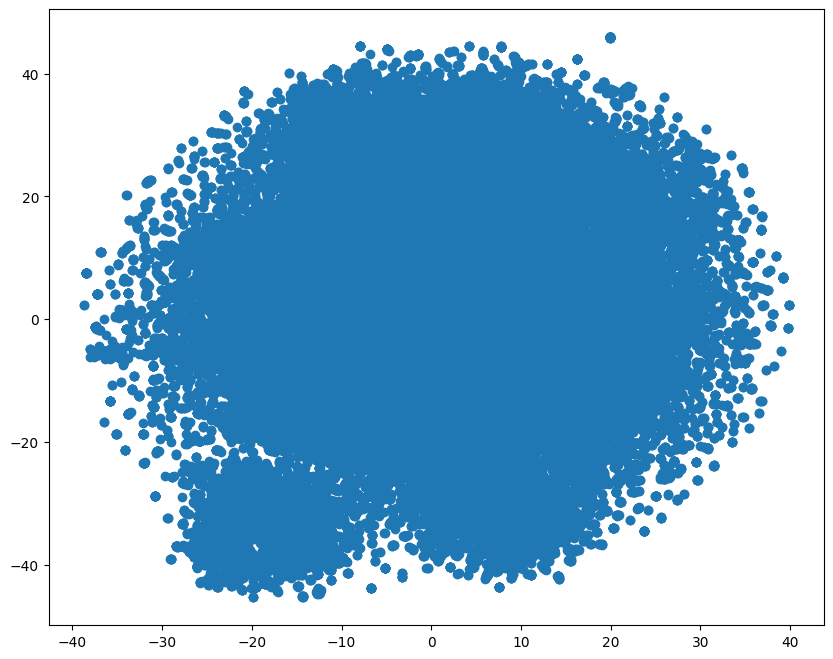

In [32]:
D_tsne = tsne.fit_transform(arrays)
plt.figure(num=None, figsize=(10, 8))  # set the figure size
plt.scatter(D_tsne[:, 0], D_tsne[:, 1])
plt.show()

In [35]:
# centroids
all_filtered_indeces = []
list_of_arrays = []
num_of_chunks = []
for s in set_of_texts:
    filtered_indeces = chunks_pd.index[chunks_pd.text_id == s].tolist()
    all_filtered_indeces.append(filtered_indeces)
    list_of_arrays.append(create_dv_list(model_dbow, chunks_pd, filtered_indeces))
    num_of_chunks.append(len(filtered_indeces))
centroids = []
for array in list_of_arrays:
    centroids.append(np.average(array, axis=0))

In [36]:
tsne = TSNE(n_components=2, perplexity = 100)

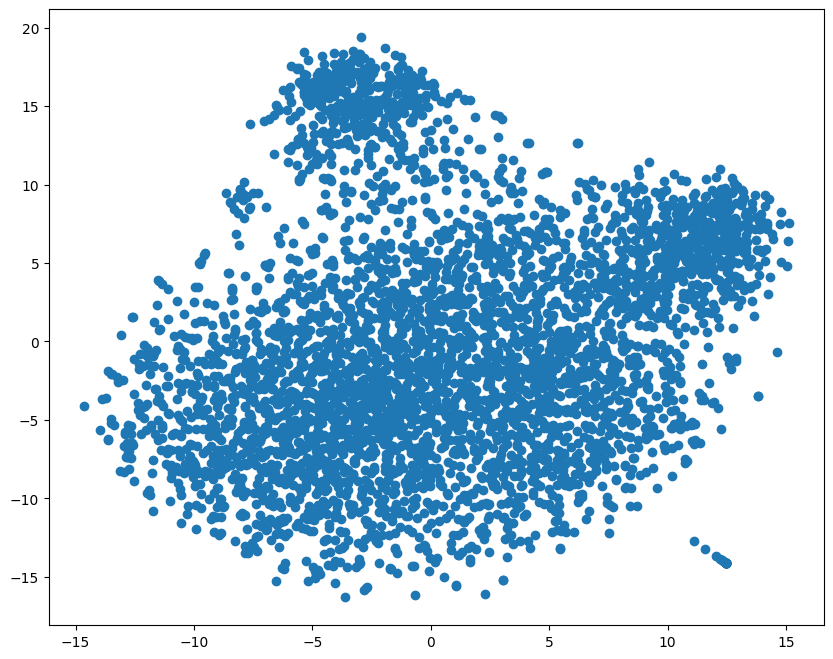

In [37]:
D_tsne = tsne.fit_transform(centroids)
plt.figure(num=None, figsize=(10, 8))  # set the figure size
plt.scatter(D_tsne[:, 0], D_tsne[:, 1])
plt.show()

In [38]:
similarities = cosine_similarity(centroids)

In [39]:
data = pd.DataFrame(similarities)

In [40]:
for i in range(0, len(data)):
    for j in range(0,len(data)):
        if i == j:
            data.iloc[i,j] = 0

In [41]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [42]:
names = f7(chunks_pd['text_id'])

In [43]:
with open('ff_chunk_ids.txt', 'w') as f:
    for name in names:
        f.write(f"{name}\n")

In [44]:
data.columns = names
data.index = names

In [45]:
data

,5fedc71c0002e78a17f6c8b0_Das-riddlesche-Kalkuel,5fedc99200090f2e36757766_Sexualkunde-in-Hogwarts,5fedeb3b000c65cf26d03006_Von-Fussbal-spielenden-Kaninchen,5fedebe8000b47f41e21882f_31-Dezember-Zwischen-den-Dimensionen-by-Sirala,5feded04000cb2621f209731_Harry-und-Hermine-unzertrennliche-Geschwister,5fee0122000b7f151ae93795_Happy-new-year,5fee0a07000b5da21bebe631_Ein-Tag-am-Strand,5fee0e48000a5a18cbd40ce_Unsichtbar-Adoptiert,5fee531c000a9dd86ce5cec_Wahre-Liebe-kann-auch-noch-spaet-erbluehen,5fee5701000c5ccc150a130d_Silvester-im-Krankenfluegel,...,43f73fd000002124067007d0_Die-Entscheidung--Ein-Leben-zwei-Wege,464f618700003693067007d0_Im-Kreisel-der-Zeit,46bc3de200002307067007d0_Die-Wahrheit-der-Vergangenheit,46cf0057000027aa067007d0_Nur-eine-Handvoll-Worte,471ce34700005391067007d0_Ende-und-Anfang--ueberarbeitet,472e0ccf00000483067007d0_Gedanken,4818839b000053e5067007d0_Advocatus-Diaboli,48502a16000087de067007d0_Ars-Magica,49be403b0000c7d6067007d0_Its-Just-The-Beginning-Not-The-End,434801b500000f6e067007d0_Was-waere-wohl-wenn
5fedc71c0002e78a17f6c8b0_Das-riddlesche-Kalkuel,0.000000,0.874504,0.547917,0.395216,0.649224,0.738930,0.481711,0.610460,0.722304,0.740633,...,0.638862,0.569450,0.454060,0.570468,0.691622,0.515506,0.437074,0.567381,0.391726,0.533886
5fedc99200090f2e36757766_Sexualkunde-in-Hogwarts,0.874504,0.000000,0.574477,0.565492,0.584850,0.825102,0.659148,0.690021,0.734628,0.651549,...,0.692606,0.568707,0.417912,0.608840,0.591459,0.579390,0.553198,0.475466,0.557954,0.560456
5fedeb3b000c65cf26d03006_Von-Fussbal-spielenden-Kaninchen,0.547917,0.574477,0.000000,0.171394,0.385827,0.572204,0.266012,0.560733,0.511400,0.554026,...,0.472192,0.550435,0.283395,0.644342,0.430123,0.491831,0.436310,0.477526,0.295082,0.273925
5fedebe8000b47f41e21882f_31-Dezember-Zwischen-den-Dimensionen-by-Sirala,0.395216,0.565492,0.171394,0.000000,0.422965,0.559816,0.629807,0.431055,0.586243,0.369111,...,0.456248,0.348155,0.379606,0.291394,0.398092,0.572420,0.409448,0.279379,0.753969,0.584653
5feded04000cb2621f209731_Harry-und-Hermine-unzertrennliche-Geschwister,0.649224,0.584850,0.385827,0.422965,0.000000,0.586256,0.441212,0.235573,0.570525,0.501793,...,0.642239,0.322673,0.263327,0.424637,0.536551,0.413608,0.280938,0.413303,0.394392,0.886384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472e0ccf00000483067007d0_Gedanken,0.515506,0.579390,0.491831,0.572420,0.413608,0.612160,0.671900,0.544870,0.558403,0.361295,...,0.519826,0.428045,0.622820,0.602076,0.659782,0.000000,0.412990,0.595112,0.695153,0.490762
4818839b000053e5067007d0_Advocatus-Diaboli,0.437074,0.553198,0.436310,0.409448,0.280938,0.732996,0.350447,0.683638,0.408474,0.462297,...,0.632430,0.575007,0.328072,0.297026,0.465989,0.412990,0.000000,0.436637,0.282230,0.323107
48502a16000087de067007d0_Ars-Magica,0.567381,0.475466,0.477526,0.279379,0.413303,0.546921,0.472636,0.554986,0.384327,0.442818,...,0.481998,0.566498,0.608738,0.408734,0.577834,0.595112,0.436637,0.000000,0.352683,0.424564
49be403b0000c7d6067007d0_Its-Just-The-Beginning-Not-The-End,0.391726,0.557954,0.295082,0.753969,0.394392,0.621084,0.679022,0.356918,0.515512,0.339386,...,0.420402,0.337360,0.580588,0.350043,0.342130,0.695153,0.282230,0.352683,0.000000,0.504278


In [46]:
G = nx.from_pandas_adjacency(data)

#### Option 1: Keep top% of links for each node

In [ ]:
# Calculate the threshold for each node
thresholds = {}
for node in G.nodes():
    # Get the weights of edges connected to the current node
    node_edges = G.edges(node, data=True)
    weights = [data['weight'] for _, _, data in node_edges]
    # Calculate the threshold for the top 10% of edges
    top_1_percent_threshold = np.percentile(weights, 90)
    thresholds[node] = top_1_percent_threshold

# Filter edges based on the thresholds
edges_to_remove = []
for u, v, data in G.edges(data=True):
    if data['weight'] < thresholds[u] or data['weight'] < thresholds[v]:
        edges_to_remove.append((u, v))

# Create a new graph with only the edges that exceed the thresholds
G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

#### Option 2: Overall threshold

In [116]:
# Set the value of N (top-N edges)
N = 10000

# Sort edges by weight
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Keep only the top-N edges
top_N_edges = sorted_edges[:N]

# Create a new graph with only the top-N edges
G_filtered = nx.Graph()
G_filtered.add_edges_from(top_N_edges)

#### Option 3: top n edges for each node

In [ ]:
# Set the number of top edges to keep per node
top_n_edges_per_node = 50

# Create a new graph to store the filtered edges
G_filtered = nx.Graph()

# Iterate over each node in the graph
for node in G.nodes():
    # Get the incident edges of the current node and their weights
    incident_edges = G.edges(node, data=True)
    edge_weights = [(u, v, data['weight']) for u, v, data in incident_edges]
    # Sort the edges by weight
    sorted_edges = sorted(edge_weights, key=lambda x: x[2], reverse=True)
    # Keep only the top N edges
    top_edges = sorted_edges[:top_n_edges_per_node]
    # Add the top edges to the filtered graph
    for u, v, weight in top_edges:
        G_filtered.add_edge(u, v, weight=weight)

In [ ]:
G_filtered.number_of_edges()
G_filtered.number_of_nodes()
df = nx.to_pandas_adjacency(G_filtered)
link_list = df.stack().reset_index()
link_list = link_list.rename(columns={"level_0": "source", "level_1": "target", 0: "weight"})
link_list_filtered = link_list[link_list["weight"] != 0]
len(set(link_list_filtered["source"]))

In [ ]:
link_list_filtered.to_csv("link_list_chunks_top50.csv")